In [1]:
%matplotlib widget

# import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.integrate import solve_ivp
from sklearn.model_selection import train_test_split
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib.colors import to_rgb, to_rgba
import matplotlib as mpl

import jax.numpy as jnp
import numpy as np
from jax import random


import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
logger = logging.getLogger(__name__)


In [5]:
Npts = 31
thetas = np.linspace(-np.pi, np.pi, Npts)
X_all = np.array([np.cos(thetas), np.sin(thetas)]).T

Y_all = np.sin(thetas)
clip = .3
# Y = np.clip(Y, -clip, +clip)
train_size = 5

equi = True
pi = np.pi
thetas_tr = np.array([-pi, 0, pi])
thetas_tr, thetas_ts = thetas_tr, thetas[~np.in1d(thetas, thetas_tr)]

i_tr = np.arange(len(thetas))[np.in1d(thetas, thetas_tr)]
i_ts = np.arange(len(thetas))[~np.in1d(thetas, thetas_tr)]

X_tr, X_ts = X_all[i_tr], X_all[i_ts]
Y_tr, Y_ts = Y_all[i_tr], Y_all[i_ts]


isort = np.argsort(thetas)
isort_tr = np.argsort(thetas_tr)
isort_ts = np.argsort(thetas_ts)

thetas = thetas[isort]
X_all = X_all[isort]
Y_all = Y_all[isort]

X_tr = X_tr[isort_tr]
Y_tr = Y_tr[isort_tr]
thetas_tr = thetas_tr[isort_tr]
i_tr = i_tr[isort_tr]

X_ts = X_ts[isort_ts]
Y_ts = Y_ts[isort_ts]
thetas_ts = thetas_ts[isort_ts]
i_ts = i_ts[isort_ts]

# kxX = k_inf_X(X, X_tr)
# kXX = k_inf_X(X_tr, X_tr)
# Y_pred = kxX @ np.linalg.inv(kXX) @ Y_tr


# put this into a Boltmann ensemble
# E = lambda y: Y.T@np.linalg.inv(K_XX_all)@Y/2

# simulate a trajectory
# this should relax quickly to a finite corr-length GP?!
# sample this from a GP, otherwise white noise might be somehow frustrating
# Y_init = np.random.normal(0, 0.1, size=len(Y))

# get the mode-dependent kernel

def F_R(K, X, resc=1.):
    # divide by lenX to have scale-invariant ODE
    F = -jnp.einsum('kl,...l', K, X) / len(X)
    # F/=resc
    # F = F/np.max(np.abs(F))

    return F

lmbd_ = 1 / len(thetas) * 100
rel_slack = 5*1e-5
k_XX_all = lmbd_*jnp.cos(thetas[:,None] - thetas[None,:]) + rel_slack*lmbd_*jnp.eye(len(thetas))

K_inv = np.linalg.inv(k_XX_all)
M = .01
omega = np.sqrt(k_XX_all.max()/M)   

def run_sim(Y_init, ts, ):
    # the kernel is the covariance of the normal distribution, hence, we shouldn't have an inverse here. 
    # NOTE: How does this relate to MSE? For this, we assume that the oscillator is 
    # Y_init = np.random.multivariate_normal([0]*len(X_all), k_XX_all)
    Y_init = Y_all*0
    # Y_init = Y
    # Y_init[i_tr] = Y[i_tr]

    v_init = random.normal(random.PRNGKey(0), (len(Y_all),), dtype=jnp.float32)*0.
    z_init = jnp.concatenate([Y_init, v_init], axis=-1)
    
    N_T = len(ts)
    N_th = len(thetas)
    # assert (np.linalg.eigvals(c_tot) >= 0.).all()

    # fig, (ax1, ax2) = plt.subplots(2,1)
    # ax1.plot(thetas, xi[0,:], label=f"lcorr={l_th}")
    # ax2.plot(ts, xi[:,0], label=f"lcorr={l_t}")
    # ax1.legend()
    # ax2.legend()
    # plt.savefig("corr.png")

    # xi = np.array([np.random.multivariate_normal(np.zeros( c_tau.shape[0]),  c_tot) for i in range(Npts)]).T
    # xi = np.concatenate([xi, xi], axis=-1)


    def f(t, z, args):
        
        x = z[...,:Npts]
        v = z[...,Npts:]

        # the force can be formulated in terms of an MSE, see manuscript_2023.lyx notes
        admittance_0_modes = 0.*.1
        
        # F = np.sin(x)*np.sum([np.cos(a*t) for a in np.geomspace(.01, 10, 10)], axis=0)
        # F = np.sin(x)*np.random.normal(0, .01, size=len(x))

        # wave drive
        F = 0.01*jnp.sin(x/2)*jnp.cos(1.*t) * 0

        F = F + F_R(K_inv, x)

        # # some dissipation to bound the energy present in the system
        gamma=.01
        F = F - gamma*v

        # # external drive
        key = random.PRNGKey((t*1000).astype(int))
        xi = random.normal(key, (len(Y_all),), dtype=jnp.float32)*0.1
        F = F + xi

        # clamp the training points
        # F[...,i_tr] = 0.
        # v[...,i_tr] = 0.

        
        return jnp.concatenate([v,F/M], axis=-1)


    from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt, PIDController

    term = ODETerm(f)
    solver = Dopri5()
    saveat = SaveAt(ts=ts)
    stepsize_controller = PIDController(rtol=1e-4, atol=1e-4)
    sol = diffeqsolve(term, solver, saveat=saveat, t0=0, t1=ts.max(), dt0=.01, y0=z_init, stepsize_controller=stepsize_controller, max_steps=None)

    ts_sol = sol.ts
    sol = sol.ys

    sol_x = sol[:,:Npts]
    sol_v = sol[:,Npts:]
    Y = sol_x

    return Y

ts = jnp.linspace(0, 1000, 1000)


logger.info("Running simulation")
Y = run_sim(Y_all, ts )
logger.info("Done")


# spectrogramm
# Parameters for STFT
window_size = len(ts) // 10  # Size of the window
overlap = int(window_size / 2)  # 50% overlap
nfft = 256  # Number of FFT points

from scipy.signal import stft

# Initialize a list to store spectrograms for each 'x'
spectrograms = []

# Compute the STFT for each 'x'
for i in range(Y.shape[1]):
    f, t_, Zxx = stft(Y[:, i], nperseg=window_size, noverlap=overlap, nfft=nfft)
    spectrograms.append(jnp.abs(Zxx)**2)

# Convert the list to a numpy array
spectrograms = jnp.array(spectrograms).mean(0)
spectrograms /= np.max(spectrograms)


2023-10-07 20:41:38,294 Running simulation


TypeError: run_sim() takes 2 positional arguments but 3 were given

/opt/homebrew/Caskroom/miniconda/base/envs/scripts/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/opt/homebrew/Caskroom/miniconda/base/envs/scripts/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/opt/homebrew/Caskroom/miniconda/base/envs/scripts/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', d

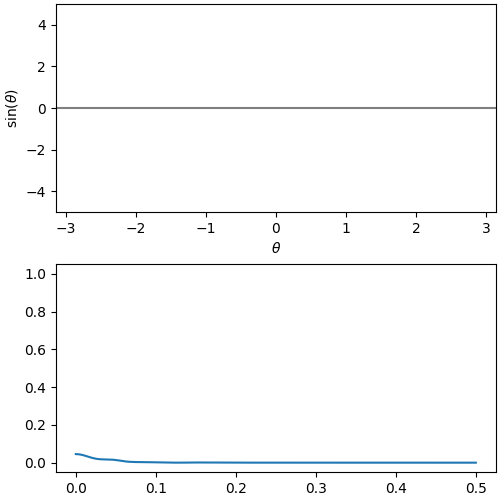

In [4]:
plt.close("all")
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(5,5), constrained_layout=True)

l, = ax1.plot(thetas, Y[0,:], 'k', alpha=0.5)
l_f, = ax2.plot(f, spectrograms[:, 0])
ax2.dataLim.y0 = 0
ax2.dataLim.y1 = 1


def update(ti):
    ax2.set_title(f"t={ts[ti]:.2f}")
    l.set_data(thetas, Y[ti,:])
    ti_spec = jnp.argmin((t_ - ts[ti])**2)
    l_f.set_data(f, spectrograms[:, ti_spec])

ax1.set_xlim(-jnp.pi, jnp.pi)
ax1.set_ylim(-5, 5)
ax1.set_xlabel(r"$\theta$")
ax1.set_ylabel(r"$\sin(\theta)$")

ax2.axvline(omega, color='k', linestyle='--')

# create the animation object
tau = 1. # in seconds
interval_ms = 1000*tau/len(ts)*jnp.diff(ts)[0]
ani = animation.FuncAnimation(fig, update, frames=len(ts), interval=interval_ms, repeat=True)
# # write out a gif
# ani.save('stochastic_resonance.gif', fps=25)
# ani

In [ ]:
ani

/opt/homebrew/Caskroom/miniconda/base/envs/scripts/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/opt/homebrew/Caskroom/miniconda/base/envs/scripts/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/opt/homebrew/Caskroom/miniconda/base/envs/scripts/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', d

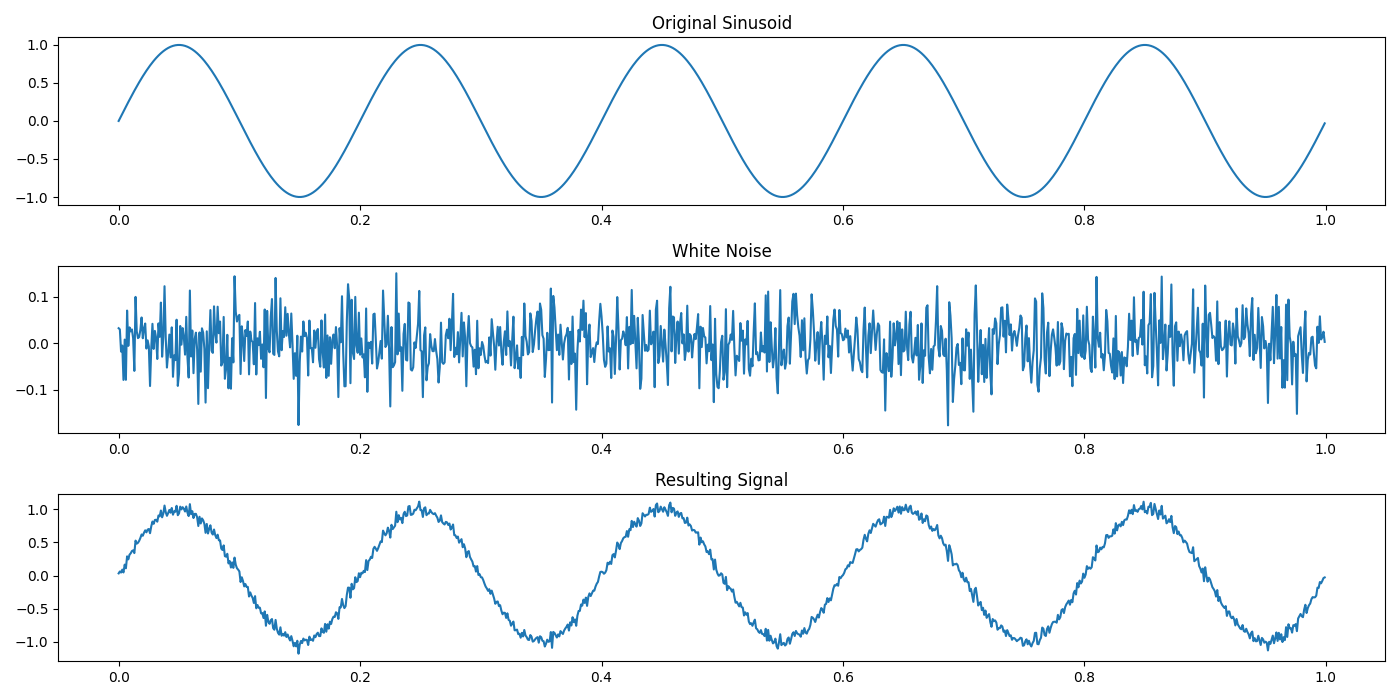

In [ ]:
# Create a time vector
t = np.linspace(0, 1, 1000, False)  # 1 second

# Create a sinusoidal signal
freq = 5  # frequency of the signal
sinusoid = np.sin(2*jnp.pi*freq*t)

# Create white noise
noise = np.random.normal(0, 0.05, 1000)

# Add the sinusoid and the noise
signal = sinusoid + noise

# Plot the original sinusoid, the noise, and the resulting signal
plt.figure(figsize=(14, 7))
plt.subplot(3,1,1)
plt.plot(t, sinusoid)
plt.title('Original Sinusoid')
plt.subplot(3,1,2)
plt.plot(t, noise)
plt.title('White Noise')
plt.subplot(3,1,3)
plt.plot(t, signal)
plt.title('Resulting Signal')
plt.tight_layout()
plt.show()


/opt/homebrew/Caskroom/miniconda/base/envs/scripts/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/opt/homebrew/Caskroom/miniconda/base/envs/scripts/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/opt/homebrew/Caskroom/miniconda/base/envs/scripts/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', d

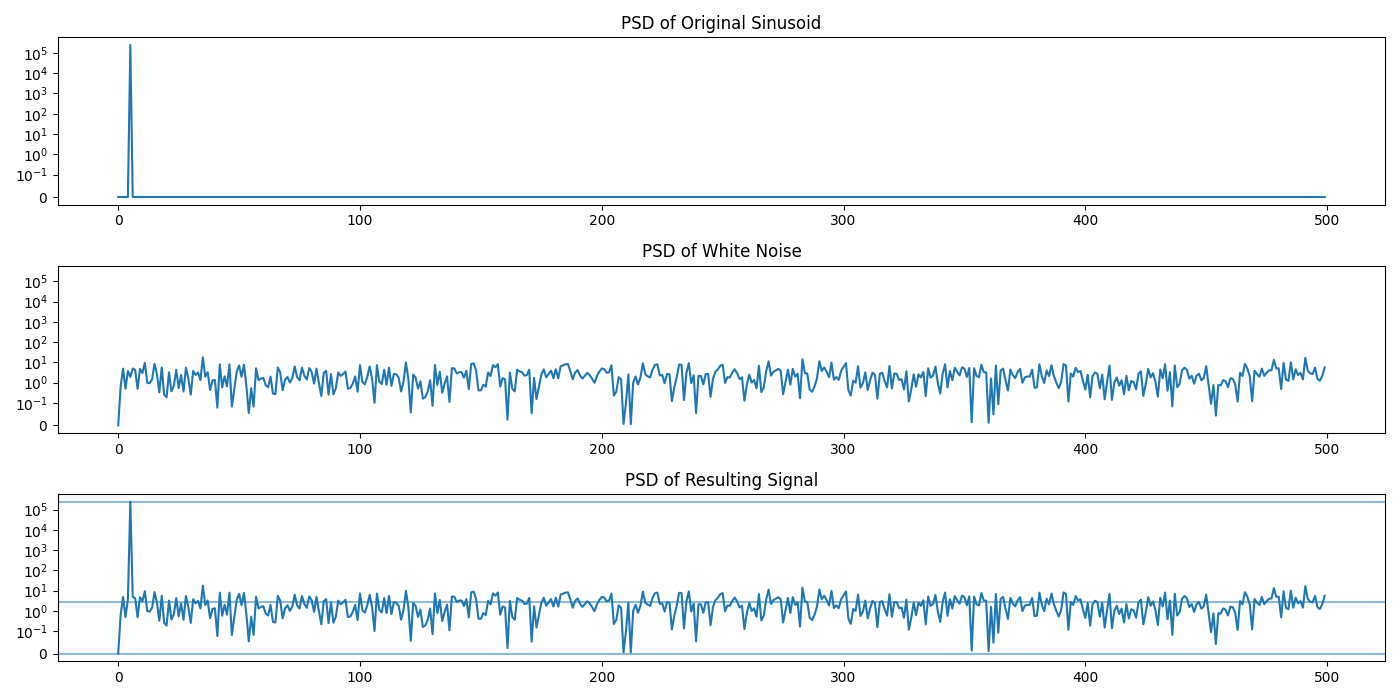

In [ ]:
# Compute the FFT
fft_sinusoid = fft(sinusoid)
fft_noise = fft(noise)
fft_signal = fft(signal)

# Compute the power spectral density
psd_sinusoid = np.abs(fft_sinusoid) ** 2
psd_noise = np.abs(fft_noise) ** 2
psd_signal = np.abs(fft_signal) ** 2

# Compute the frequencies corresponding to the values of the PSD
freqs = np.fft.fftfreq(len(sinusoid), t[1]-t[0])

# Plot the power spectral density
fig, axs = plt.subplots(3, 1, figsize=(14, 7), sharey=True)
axs[0].plot(freqs[:len(freqs)//2], psd_sinusoid[:len(psd_sinusoid)//2])
axs[0].set_title('PSD of Original Sinusoid')
axs[1].plot(freqs[:len(freqs)//2], psd_noise[:len(psd_noise)//2])
axs[1].set_title('PSD of White Noise')
axs[2].plot(freqs[:len(freqs)//2], psd_signal[:len(psd_signal)//2])
axs[2].set_title('PSD of Resulting Signal')
axs[2].set_yscale("symlog", linthresh=1e-1)

axs[2].axhline(0, zorder=-1, alpha=.5)
axs[2].axhline(np.mean(psd_noise), zorder=-1, alpha=.5)
axs[2].axhline(np.max(psd_signal), zorder=-1, alpha=.5)
fig.tight_layout()
plt.show()
